<h1 style="text-align: center">Principal Component Analysis</h1> <h2 style="text-align: right">--- Gautam Arakalgud (garakalg)</h2>

## Introduction
This tutorial is designed to give the reader an intuitive understanding of principal component analysis (PCA) and its applications in analyzing large datasets as well as data compression. While the tutorial will largely focus on the high level ideas behind PCA, it also gives you a chance to understand the mathematics behind the theory.

In today's world, it is very important that we are able to use exisiting computing resources to store, analyze and work with growing data. For instance, we could be estimating facial expressions from images shot with a 1MP camera. Treating raw pixel values as image features, we have a million features for every image. Running standard machine learning algorithms on these images would require a great deal of computing power and time. However, it is often found that most features in high dimensional datasets are redundant and this _information_ can be contained in a much smaller number of features. PCA deals with effectively trying to identify those features that can capture the _essence_ of the data and represent the data in this lower dimensional feature space.

## Contents
This tutorial will cover the following topics:
- [The Olivetti Faces Dataset](#The-Olivetti-Faces-Dataset)
- [Visualizing the dataset](#Visualizing-the-dataset)
- [Math for PCA](#Math-for-PCA)
- [Computing eigen values and vectors](#Computing-eigen-vectors-and-corresponding-eigen-values)
- [Projecting data](#Projecting-data-onto-the-principal-vectors-and-Reconstruction)
- [Visualizing reconstructed data](#Visualizing-reconstructed-images)
- [Gram Matrix Trick](#Gram-Matrix-Trick)
- [Using PCA for classification](#Using-Dimensionality-reduction-for-classification)

## The Olivetti Faces Dataset
The [Olivetti Database of Faces][odb] consists of 10 images each of 40 distinct subjects. The images were captured in natural environments at different times, with different lighting, facial expressions(smiling/not smiling) and facial details(glasses/no glasses).
Each image in the dataset is of size 64x64 pixels. The image is quantized to 256 grayscale levels, but the loader converts this to floating point values in the interval [0 1]. We shall apply PCA and some basic (supervised) machine learning algorithms to this dataset and the see the effect of PCA on accuracy, and dependency on computing power and time. The dataset is loaded from the sklearn datasets.

We shall first import the required libraries and load the database with the images arranged in a random permutation. This is achieved by setting "shuffle=True" while loading the dataset.
[odb]: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

In [17]:
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_olivetti_faces
from matplotlib import pyplot as plt
import scipy.sparse as sp

rnd = np.random.RandomState(2)                                      # Use a fixed seed for consistency
dataset = fetch_olivetti_faces(shuffle=True, random_state=rnd)      # Load the Olivetti_Faces_dataset
image_shape = (64, 64)

## Visualizing the dataset
The first step towards addressing any datascience problem must always be to visualize the dataset and understand it before running algorithms on it, and that is what is done here. A small helper function is written to plot a gallery of images in a 3x3 grid. We can then see a small preview of the kind of images this dataset contains. We plot 9 randomly chosen images from the dataset.

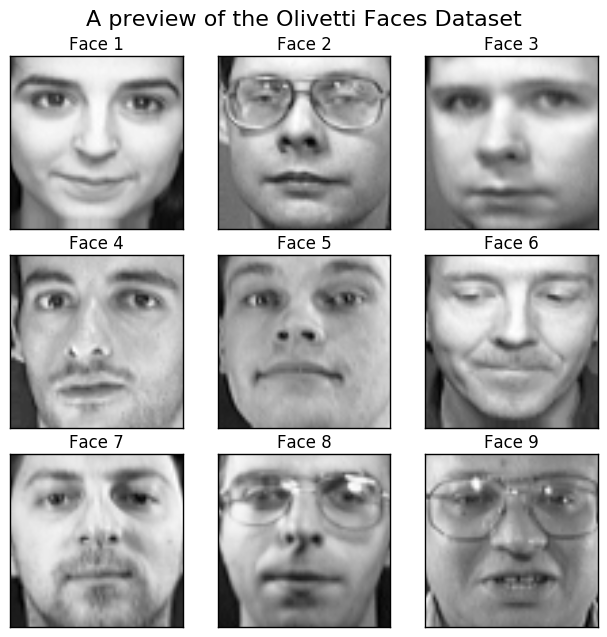

In [8]:
def plot_gallery(title, subtitle, images, n_col, n_row, n):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        ax = plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        ax.set_title("{} {}".format(subtitle, (i+1)*n))
        ax.imshow(comp.reshape(image_shape), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.20, 0.)

plot_gallery("A preview of the Olivetti Faces Dataset", "Face", dataset.data[:9, :], 3, 3, 1)
plt.show()

## Math for PCA
Let's take a small and quick detour to write down and intuitively understand some of the mathematics behind the PCA formulation. We can think of our data (images) as points in a high dimensional (64\*64 to be precise) space. We have 400 data points in a 4096 dimensional feature space. The core idea behind PCA is to pick **principle vectors** in the original high dimensional feature space and project our data onto these vectors, thus going down to a lower dimensional space (described by these vectors) while preserving most of the _important information_ in our data. The way PCA achieves this, is by picking out the vectors whose directions in the original feature space represent the maximum variance of the data. Hence PCA uses **variance** as a primary measure in compressing data into a smaller feature space. To apply PCA, we commonly calculate the covariance matrix of the data.

### Notation:
$d$: Number of features <br\>
$N$: Number of samples <br\>
$X$: Data (Arranged dxN) <br\>
$\omega$: Principal vector (1xd) <br\>
$\mu$: Mean of the data (1xd)

**Important**: Variance (or covariance) is always defined for data that is centered (meaned) at the origin. We must thus subtract the mean before running PCA on the data.


## Computing eigen vectors and corresponding eigen values
The PCA objective is that we want to find projections of the data (i.e directions onto which the data can be projected) that describe the maximum variance or scatter in the data. Let us look at this as an optimization problem. 
$$
\begin{align*}
max. \>\> J(\omega) & = var(\omega^T*X) \\
& = E(\omega^TX - \omega^T\mu)^2 \\
& = E(\omega^TX - \omega^T\mu)(X^T\omega - \mu^T \omega) \\
& = \omega^TE[(X-\mu)(X-\mu)^T]\omega \\
& = \omega^T \Sigma \omega
\end{align*}
$$
where $\Sigma = E[(X-\mu)(X-\mu)^T]$ is the covariance matrix.

We maximize $J(\omega)$ subject to the contstraint that the projection vectors are unit norm. ($\implies ||\omega||=1$)

We solve the Legrangian formulation
$$
L(\omega, \lambda) = \omega^T\Sigma\omega - \lambda(\omega^T\omega - 1) \\
\frac{\partial L(\omega, \lambda)}{\partial \omega} = 2\Sigma\omega - 2\lambda\omega = 0 \\
\Sigma\omega = \lambda \omega \\
$$
This is a standard eigenvalue / eigen vector problem. The vectors $\omega$ are in fact the eigen vectors of the covariance matrix $\Sigma$ and the vectors corresponding to the highest eigen values are the ones that descibe the highest variation in the original data. Let us implement this with the face dataset.  

In [2]:
'''
eig() returns a sorted numpy array of eigen values and corresponding 
normalized eigen vectors as the columns of a square matrix.
'''

def covariance_eig(data):
    covariance_data = data.dot(data.T)
    eig, V = np.linalg.eig(covariance_data)
    eig = np.real(eig)
    V = np.real(V)
    return (eig, V)

In [3]:
img = dataset.data                                  # Load the data in the format that we need
img_mean = img.mean(axis=0)                         # We store the mean of the image because we need it to reconstruct the image.
centered_img = img - img_mean              # Remove the mean  from every image.
%time eig, V = covariance_eig(centered_img.T)       # Calculate the covariance matrix and principal vectors of the data

CPU times: user 9min 17s, sys: 4min 48s, total: 14min 5s
Wall time: 4min 56s


Now that we have our eigen vectors and their corresponding eigen values, we can pick the top _k_ eigen vectors that maximize the variance in the data and project our data along these vectors. By doing this, we are effectively reducing the dimentionality of our data from the original high dimensional space to k dimensions.

The question of how many eigen vectors to pick is an important one. It largely depends on what purpose the PCA is trying to achieve. For instance, you could be performing PCA for data compression, for classification, etc. One good approach is to list the eigen values in descending order and calculate the amount of variance retained by picking the top k eigen vectors. This is known as the reconstruction capability and explains how well the chosen principal vectors can reconstruct the original data. By "good reconstruction", we usually mean reducing the mean square errors between the original and reconsructed data.
$$Reconstruction \> \% = \frac{\sum_{i=1}^k \lambda_i}{\sum_{i=1}^N \lambda_i}$$
We can write a small script that plots the reconstruction capability against the number of eigen vectors chosen.

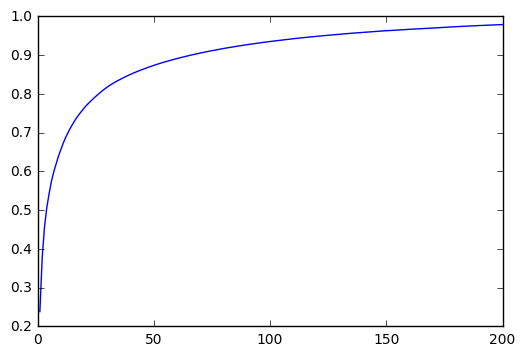

Reconstruction capability of the first 200 eigen vectors: 97.9051232338%


In [53]:
cumulative_eig = np.cumsum(eig)
cumulative_eig = cumulative_eig/float(cumulative_eig[-1])
plt.plot(range(1, 201), cumulative_eig[:200])
plt.show()
print "Reconstruction capability of the first 200 eigen vectors: {}%".format(cumulative_eig[199]*100)

We notice something very interesting by just plotting the reconstruction capability for the first 200 (out of a potential 4096) eigen vectors. The first 200 principal vectors describe ~98% of the variance of the data. What this means is that we could reduce the dimentionality of our data from the original 4096 dimensional space to a 200 dimentional space with just 2% loss in information. We are effectively reducing the size of our data by almost 200 times! Sometimes, we may not even need these many principal vectors. To get a reconstruction capability of 80%, we'd need only 27 eigen vectors.

## Projecting data onto the principal vectors and Reconstruction
We can write a function that takes in as input the data matrix and the principal vectors and projects the data onto these vectors.

In [5]:
def project(data, principal_vectors):
    data = data - img_mean
    project_data = data.dot(principal_vectors)
    return project_data

Now that we have the new data projected onto the low dimensional feature space, we can store or run algorithms on this low compressed data. The next step should be to visually see close the compressed data is to the actual data and calculate the mean square error between the original and reconstructed data.

**Important:** We subtracted the mean from the original image and projected the centered_image. Remember to add the mean back to the reconstructed data. 

In [54]:
def reconstruct(project_data, principal_vectors):
    reconstruct_data = project_data.dot(principal_vectors.T)
    reconstruct_data = reconstruct_data + img_mean
    return reconstruct_data

## Visualizing reconstructed images
We begin by visualizing the most dominant principal vectors and see what kind of information these vectors contain. We continue this analysis by choosing an image and projecting it on the first k principal vectors and vary k.

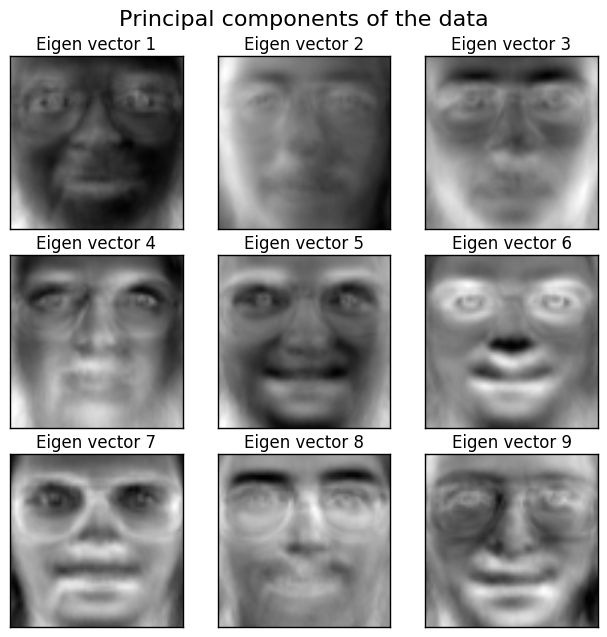

In [9]:
eigen_components = np.zeros((9, dataset.data.shape[1]))
eigen_components = V[:, :9].T
plot_gallery("Principal components of the data", "Eigen vector", eigen_components, 3, 3, 1)
plt.show()

(4096, 4096)
(4096,)


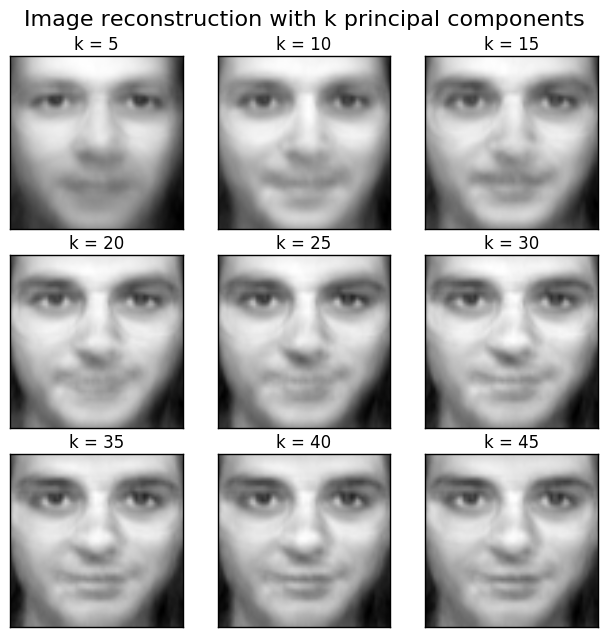

In [27]:
dom_eigen = np.zeros((9, dataset.data.shape[1]))
print V.shape
print dataset.data[0].shape
for i in xrange(9):
    project_data = project(dataset.data[0], V[:, :5*(i+1)])
    reconstruct_data = reconstruct(project_data, V[:, :5*(i+1)])
    dom_eigen[i] = reconstruct_data
plot_gallery("Image reconstruction with k principal components", "k =", dom_eigen, 3, 3, 5)
plt.show()

While it seems obvious that increasing the number of principal vectors gives us better reconstruction, we can visually see that this is true.

## MSE of reconstructed images
A good metric for the amount of information loss is to calculate the mean square error between the original and reconstructed images. We take 4 cases, by choosing 5, 20, 50 and 400 principal vectors.

In [10]:
rec_images = np.zeros((4, dataset.data.shape[1]))
principal_vec = [5, 20, 50, 400]
for i,k in enumerate(principal_vec):
    project_data = project(dataset.data[0], V[:, :k])
    reconstruct_data = reconstruct(project_data, V[:, :k])
    rec_images[i] = reconstruct_data
mse = np.sum(((rec_images-dataset.data[0])**2), axis=1)/float(rec_images.shape[1])
print mse

[  9.46010545e-03   4.56969746e-03   2.24048652e-03   4.96826193e-14]


We get good reconstruction with k = 5, 20 and 50 and near perfect reconstruction by using 400 eigen vectors (as expected).

## Gram Matrix Trick
In this example we are working with images of size 64x64 pixels, and this gives us feature vectors of size 4096 (d). However, we just have 400 (N) sample images. This is most often the case when we deal with computer vision problems. The feature size far exceeds the number of samples we have. The covariance matrix that we compute is correspondingly of size 4096x4096. As the size of these images increases, it becomes computationally infeasible to compute these large matrices. For instance, if we were dealing with 1MP images, we'd be generating a $10^6*10^6$ covaraince matrix, and we wouldn't be able to store a matrix this large on our computer. Added to this is the fact that we have only N samples (N << d) and can have at most N-1 eigenvectors (assuming that our data is linearly independent). Hence, it would make more sense to calculate an $N*N$ covariance matrix and work with this matrix.

We know that 
$$
\Sigma = E[(X-\mu)(X-\mu)^T]
$$
We must solve for 
$$
\begin{align*}
\Sigma v & = \lambda v \\
XX^Tv & = \lambda v \\
X^TXX^Tv & = \lambda X^Tv \> \> \text{(pre-mult by }X^T) \\
\text{Setting }(v' & = X^Tv), \\
X^TXv' & = \lambda v' \implies \text{Eigen value problem}
\end{align*}
$$
However, once we solve for the eigen values and eigen vectors, we must get back the principal vectors of the original data, as these are the vectors on which we can project our data onto.
$$
\begin{align*}
XX^Tv & = \lambda v \\
v' & = X^Tv \\
\implies Xv' & = \lambda v \\
\implies v & = \frac{1}{\lambda}Xv'
\end{align*}
$$
We can now go ahead and solve for the new covariance matrix and the corresponding principal vectors.

In [11]:
gram_img = centered_img
print gram_img.shape
%time eig_gram, V_gram = covariance_eig(gram_img)
print V_gram.shape

(400, 4096)
CPU times: user 1.9 s, sys: 3.04 s, total: 4.94 s
Wall time: 1.46 s
(400, 400)


We can compare the time that it took for the computation of the covariance and eigen vector matrices for the original data and using the gram matrix trick. Using the gram matrix trick and computing the covariance matrix and principal components for the transposed data matrix took 1s as against 2.5 minutes for computing it for the original data. This is a pretty big speedup. Further, we're now just storing 400 principal vectors rather than the original 4096 principal vectors. It's easy to see why this computation is beneficial. We can now project and reconstruct the same image that we had earlier to see if we get similar results.

## Recovering original eigen vectors
Before we can project our data, we must recover the original principal vectors. This is done by following the equation derived above. 

In [12]:
def recover(data, V_gram):
    V_orig = data.T.dot(V_gram)
    V_orig = normalize(V_orig, axis=0)
    return V_orig

We can verify that the recovered eigen vectors from the gram matrix trick are identical to the original principal vectors generated from the data itself. In short, V_orig must be identical to V. We can resontruct the same image that we'd chosen earlier to verifiy this.

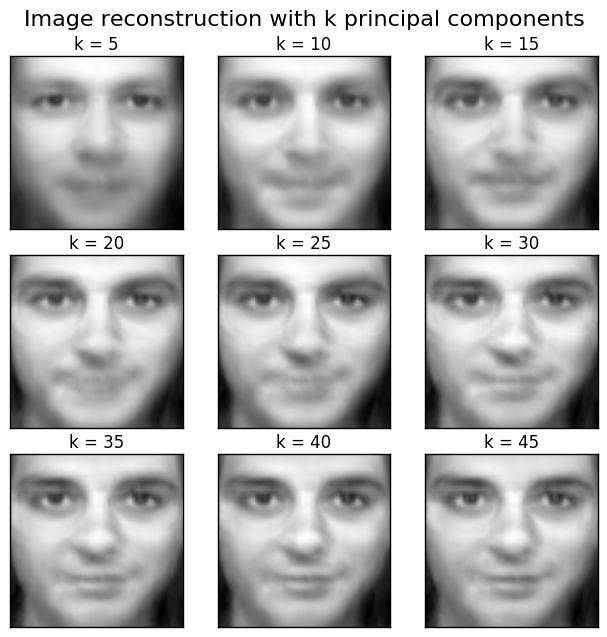

In [33]:
dom_eigen = np.zeros((9, dataset.data.shape[1]))
for i in xrange(9):
    project_data = project(dataset.data[0], V_orig[:, :5*(i+1)])
    reconstruct_data = reconstruct(project_data, V_orig[:, :5*(i+1)])
    dom_eigen[i] = reconstruct_data
plot_gallery("Image reconstruction with k principal components", "k =", dom_eigen, 3, 3, 5)
plt.show()

## Using Dimensionality reduction for classification
Let us now train and build a classification algorithm to classify these images. The dataset contains 10 images each of 40 distinct people and we can use it to perform face recognition. We use the softmax loss for this multiclass classification in a similar fashion as we did to classify handwritten digits in assignment 4.

Let us define the loss and gradient functions 

In [52]:
def softmax_loss_grad(X, Theta, y):
    m = y.shape[0]
    y_mat = sp.csr_matrix((np.ones(m), (y, np.arange(m))))
    y_mat = np.array(y_mat.todense()).T
    hyp = X.dot(Theta)
    prob = ((np.exp(hyp)).T/(np.sum(np.exp(hyp), axis=1))).T
    loss = -sum((sum(y_mat*np.log(prob))))/m
    grad = (-1/float(m))*X.T.dot(y_mat-prob)
    return (loss, grad)

def softmax_gd(X, y, lam=1e-5, alpha=1.0):
    theta = np.zeros((X.shape[1], len(np.unique(y))))
    prev_loss = np.inf
    while True:
        loss, grad = softmax_loss_grad(X, theta, y)
        grad += lam*theta
        theta = theta - alpha*grad
        if abs(prev_loss-loss) < 1e-5:
            break;
        prev_loss = loss;
    return theta

def predict(X_test, theta):
    hyp = X_test.dot(theta)
    pred = hyp.argmax(axis=1)
    return pred

We can use 80% (320 images) as our training set and the remaining 20% (80 images) as our testing set.

With PCA:

In [44]:
project_data = project(dataset.data, V[:, :50])
X_train = project_data[:320]
X_test = project_data[320:400]
y_train = dataset.target[:320]
y_test = dataset.target[320:400]

theta = softmax_gd(X_train, y_train)
pred = predict(X_test, theta)
err = len(np.where(pred != y_test)[0])/float(len(y_test))
print err

0.025


Without PCA:

In [4]:
X_train = dataset.data[:320]
X_test = dataset.data[320:400]

theta = softmax_gd(X_train, y_train, alpha=0.05)
pred = predict(X_test, theta)
err = len(np.where(pred != y_test)[0])/float(len(y_test))
print err

0.022


While classification on the original data (without PCA) unsurprisingly performs better than with PCA, the difference in accuracy is very small. The amount of time and computing required, however, to perform this classification is much lesser with PCA. It's always a trade-off between accuracy and required computing power.